In [1]:
from models.dcgan import DCGAN
from models.discriminator import create_discriminator
from models.generator import create_generator, test_generator
from keras.optimizers import Adam
from utils.image_utils import read_collection
from utils.file_utils import make_directory
from utils.benchmark_utils import time_stamp, get_time
from utils.visualization_utils import save_plot
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import config

2023-03-02 12:58:35.450404: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
generator = create_generator(z=config.Z_DIM)
discriminator = create_discriminator(img_shape=config.IMG_SHAPE)

2023-03-02 12:58:39.261022: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
generator.compile(loss='binary_crossentropy',
                 optimizer=Adam(learning_rate=0.0002, beta_1=0.4))

In [4]:
discriminator.compile(loss='binary_crossentropy', 
                     optimizer=Adam(learning_rate=0.0002, beta_1=0.4),
                      metrics=['accuracy'])

In [5]:
discriminator.trainable = False

In [6]:
dcgan = DCGAN(generator, discriminator)
dcgan.compile(loss='binary_crossentropy',
             optimizer=Adam())

In [7]:
discriminator_losses = []
gan_losses = []

In [8]:
data_images = read_collection(config.DATA_TRAINING_PATH, 'jpg')

In [9]:
time_stamp("Generating labels ...", get_time())
real_labels = np.ones((config.BATCH_SIZE, 1))
fake_labels = np.zeros((config.BATCH_SIZE, 1))
time_stamp("Finishing ...", get_time())

Generating labels ... - Thu Mar  2 12:58:41 2023
Finishing ... - Thu Mar  2 12:58:41 2023


In [10]:
make_directory(config.MODEL_FOLDER_NAME)
make_directory(f'{config.MODEL_FOLDER_NAME}/predictions')

In [11]:
ls

Dementia_GAN.ipynb  Untitled.ipynb      model-py-test/      trained-models/
LICENSE             __pycache__/        models/             utils/
Lapses.ipynb        config.py           results/
README.md           data/               train.py


1/1 [==============================] - 0s 88ms/step


1/1 [==============================] - 0s 89ms/step
Iteration 100, [D loss: 0.676013, acc.:56.25%] [G loss: 0.045056]
1/1 [==============================] - 0s 86ms/step


1/1 [==============================] - 0s 79ms/step
Iteration 200, [D loss: 0.589714, acc.:73.44%] [G loss: 0.023068]
1/1 [==============================] - 0s 85ms/step


KeyboardInterrupt: 

<Figure size 216x216 with 0 Axes>

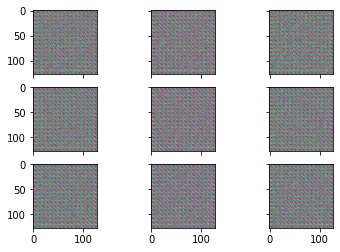

<Figure size 216x216 with 0 Axes>

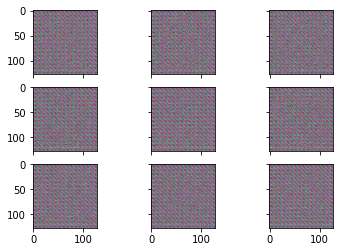

In [12]:
for iteration in range(config.ITERATIONS):
    # Collect batch
    random_indicies = np.random.choice(
        len(data_images),
        size=config.BATCH_SIZE,
        replace=False)
    real_image_batch = np.array([data_images[i] for i in random_indicies]) / 127.5 - 1.0 # rescale [-1, 1]
    
    # Random batch of fake images
    z_fake = tf.random.normal([config.BATCH_SIZE, config.Z_DIM])
    generated_images = generator.predict(z_fake)
    
    # Train discriminator
    discriminator_real_loss = discriminator.train_on_batch(real_image_batch, real_labels)
    discriminator_fake_loss = discriminator.train_on_batch(generated_images, fake_labels)
    
    # Get discriminator loss and accuracy
    discriminator_loss, accuracy = 0.5 * np.add(discriminator_real_loss, discriminator_fake_loss)
    
    # Train generator
    z_fake = tf.random.normal([config.BATCH_SIZE, config.Z_DIM])
    generated_images = generator.predict(z_fake)
    
    # Get generator loss and accuracy
    gan_loss = dcgan.train_on_batch(z_fake, real_labels)
    
    # Append data
    discriminator_losses.append(discriminator_loss)
    gan_losses.append(gan_loss)
    
    # Progress output
    if (iteration + 1) % config.SAMPLE_INTERVAL == 0:
        print("Iteration %d, [D loss: %f, acc.:%.2f%%] [G loss: %f]" %( iteration+1, discriminator_loss, 100.0*accuracy, gan_loss))
        
        # Generate random images
        z_generated = tf.random.normal([3*3, 128])
        generate_images = generator.predict(z_generated)
        generate_images = 0.5 * generate_images + 0.5
        
        # Plot
        fig = plt.figure(figsize=(3, 3))
        fig, axs = plt.subplots(3, 3, sharex=True, sharey=True)
        
        cnt = 0
        for i in range(3):
            for j in range(3):
                # Get images from batch at index 'cnt'
                axs[i, j].imshow(generate_images[cnt])
                cnt += 1
        plt.savefig(f'{config.MODEL_FOLDER_NAME}/predictions/{iteration+1}.png')

In [ ]:
plt.clf()
save_plot(discriminator_losses, 'Discriminator Loss', config.MODEL_FOLDER_NAME, 'discriminator_loss')

In [ ]:
plt.clf()
save_plot(gan_losses, 'Gan Loss', config.MODEL_FOLDER_NAME, 'gan_loss')